In [35]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Add the src directory to the path
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))

# Import the BaseAgent class
from src.agents.base_agent import BaseAgent

from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Display the BaseAgent class documentation
#help(BaseAgent)

## Amiral

### TOOLS

In [114]:
### DISCRETIZATION OF POSITION TO LOCATION ON MAP 
def position_to_loc(x, y, grid_size=32):
    loc = 0
    if y < grid_size * (1/2) and x < grid_size * (1/4):
        loc = 1
    if y < grid_size * (1/2) and x >= grid_size * (1/4):
        loc = 4
    if y < grid_size * (1/2) and x < grid_size * (1/2) and x >= grid_size * (1/4):
        loc = 3
    if y < grid_size * (1/2) and x >= grid_size * (1/2) and x < grid_size * (3/4):
        loc = 2

    if y >= grid_size * (1/2) and x < grid_size * (1/4):
        loc = 5
    if y >= grid_size * (1/2) and x >= grid_size * (1/4):
        loc = 6
    if y >= grid_size * (1/2) and y < grid_size * (3/4):
        if x >= grid_size * (1/4) and x < grid_size * (3/8):
            loc = 7
        if x >= grid_size * (3/8) and x < grid_size * (4/8):
            loc = 9
        if x >= grid_size * (4/8) and x < grid_size * (5/8):
            loc = 8
        if x >= grid_size * (5/8) and x < grid_size * (6/8):
            loc = 10

    if y >= grid_size * (3/4) and y < grid_size - 2:
        if x >= grid_size * (1/4) and x < grid_size * (3/8):
            loc = 11
        if x >= grid_size * (3/8) and x < grid_size * (4/8):
            loc = 13
        if x >= grid_size * (4/8) and x < grid_size * (5/8):
            loc = 12
        if x >= grid_size * (5/8) and x < grid_size * (6/8):
            loc = 14
    
    if y >= grid_size - 2:
        if x < grid_size * (3/8):
            loc = 15
        if x >= grid_size * (3/8) and x < grid_size * (4/8):
            loc = 17
        if x >= grid_size * (4/8) and x < grid_size * (5/8):
            loc = 16
        if x >= grid_size * (5/8):
            loc = 18
    return loc

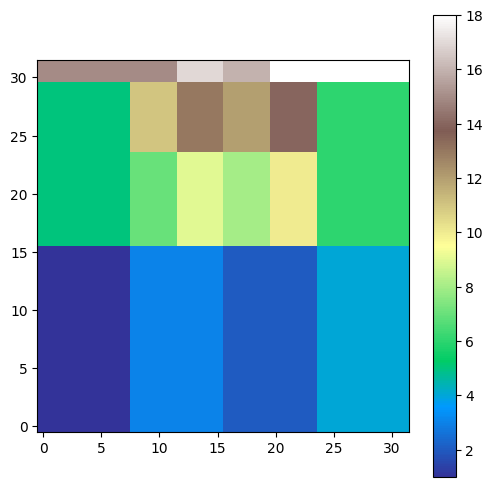

In [115]:
matrice = np.zeros((32,32))

for x in range(32):
    for y in range(32):
        matrice[y][x] = position_to_loc(x, y)
        
plt.figure(figsize=(6, 6))
plt.imshow(matrice, cmap='terrain')
plt.colorbar()
plt.gca().invert_yaxis()  # Inversion de l'axe Y
plt.show()


In [116]:
def actions_to_dir(i:int):
    if i < 0 or i >= 8:
        u = (0,0)
        return u
    if i == 0:
        u = (0,1)
    if i == 1:
        u = (1,1)
    if i == 2:
        u = (1,0)
    if i == 3:
        u = (1,-1)
    if i == 4:
        u = (0,-1)
    if i == 5:
        u = (-1,-1)
    if i == 6:
        u = (-1,0)
    if i == 7:
        u = (-1,1)

    ux, uy = u
    n_u = np.sqrt(ux**2 + uy**2)
    return u / n_u    

def dir_to_goal(x,y,x_g=16.,y_g=31.):
    ux = x_g - x
    uy = y_g - y
    n_u = np.sqrt(ux**2 + uy**2)
    if n_u > 0:
        ux = ux / n_u
        uy = uy / n_u
        return (ux, uy)
    else:
        return (0,0)

def rosace_des_vents(x,y,x_g=16.,y_g=31.):
    directions = np.zeros(9)
    dir_g = dir_to_goal(x,y,x_g=x_g ,y_g=y_g)

    for action in range(0,9):
        u = actions_to_dir(action)
        dot = np.dot(u, dir_g)
        directions[action] = dot
    return directions


In [ ]:
def get_wind(x, y, observation):
    

### TESTING TOOLS

In [118]:
def test(sailor: Amiral, num_test=50, max_steps=150, seed = None):
    """Simple testing method during training to show improvements of results without exploration"""

    # Turn off exploration for evaluation
    exploration_rate = sailor.exploration_rate
    sailor.exploration_rate = 0

    print("------ BEGINNING TEST -------------------------------                                ")
    print(f"exploration rate set to : {sailor.exploration_rate}")

    # Create test environment
    dico_env = {}
    dico_env[1] = SailingEnv(**get_initial_windfield('training_1'))
    dico_env[2] = SailingEnv(**get_initial_windfield('training_2'))
    dico_env[3] = SailingEnv(**get_initial_windfield('training_3'))

    i = np.random.randint(1, 4)
    test_env = dico_env[i]

    print(f"Testing the trained agent on {num_test} new episodes...")
    # Testing loop
    results_steps = []
    results_rew = []
    results_avg_speed = []

    for episode in range(num_test):
        if seed is None:
            a_seed = 100000+episode
        else:
            a_seed = seed[episode]

        # Reset environment
        sailor.clear_history()
        observation, info = test_env.reset(seed=a_seed)  # Different seeds from training
        
        total_reward = 0
        
        for step in range(max_steps):
            # Select action using learned policy
            action = sailor.act(observation)
            observation, reward, done, truncated, info = test_env.step(action)
        
            total_reward += reward*np.power(sailor.discount_factor, step)
            
            # Break if episode is done
            if done or truncated:
                results_steps.append(step)
                results_rew.append(total_reward)
                results_avg_speed.append(sailor.get_avg_veloc())
                break
        
        if not(done):
            results_steps.append(step)
            results_rew.append(0)
            results_avg_speed.append(-1)
    
    sailor.exploration_rate = exploration_rate
    print(f"exploration rate re-set to : {sailor.exploration_rate}")
    print("------ END OF TEST ----------------------------------                                ",end="\n")
        
    return results_steps, results_rew, results_avg_speed


### CLASS

In [ ]:
class Amiral(BaseAgent):
    """A TD(λ) agent with eligibility traces using a Q-table."""

    def __init__(self, learning_rate=0.1, discount_factor=0.99, exploration_rate=0.1, lambda_=0.8):
        super().__init__()
        self.np_random = np.random.default_rng()
       
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.lambda_ = lambda_

        self.position_bins = 16
        self.velocity_bins = 8
        self.wind_bins = 8
        self.goal_x = 16.
        self.goal_y = 31.

        self.q_table = {}
        self.eligibility = {}
        self.q_visit = {}
        self.polar = {}

        # only for history
        self.training_session = 0
        self.hist_pos = []
        self.hist_veloc = []

    def discretize_state(self, observation):
        x, y = observation[0], observation[1]
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]

        grid_size = 32
        x_bin = min(int(x / grid_size * self.position_bins), self.position_bins - 1)
        y_bin = min(int(y / grid_size * self.position_bins), self.position_bins - 1)

        v_magnitude = np.sqrt(vx**2 + vy**2)
        if v_magnitude < 0.1:
            v_bin = 0
        else:
            v_direction = np.arctan2(vy, vx)
            v_bin = int(((-wind_direction + 1/2*np.pi) / (2 * np.pi) * (self.velocity_bins - 1)) + 1) % self.velocity_bins

        wind_direction = np.arctan2(wy, wx)
        wind_bin = int(((-wind_direction + 1/2*np.pi) / (2 * np.pi) * self.wind_bins)) % self.wind_bins

        # Storing data
        self.hist_pos.append((x, y))
        self.hist_veloc.append((vx, vy))

        return (x_bin, y_bin, v_bin, wind_bin)

    def act(self, observation):
        state = self.discretize_state(observation)

        x, y = observation[0], observation[1]
        wx, wy = observation[4], observation[5]
        wind_direction = np.arctan2(wy, wx)

        wind_bin = int(((wind_direction + np.pi) / (2 * np.pi) * self.wind_bins)) % self.wind_bins
        wind_mag = int(4*np.sqrt(wx**2 + wy**2))

        if self.np_random.random() < self.exploration_rate/3:
            return self.np_random.integers(0, 9)

        elif self.np_random.random() < self.exploration_rate:
            v = np.zeros(9)
            directions = rosace_des_vents(x,y,x_g=self.goal_x, y_g=self.goal_y)
            for action in range(0, 9):
                self.polar.setdefault((wind_bin, wind_mag, action),[0])
                v[action] = (np.mean(self.polar[(wind_bin, wind_mag, action)]))
            best_course = directions * v
            return np.argmax(best_course)

        else:
            if state not in self.q_table:
                self.q_table[state] = np.zeros(9)
            return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, next_action):
        self.q_table.setdefault(state, np.zeros(9))
        self.q_table.setdefault(next_state, np.zeros(9))
        self.eligibility.setdefault(state, np.zeros(9))

        self.q_visit.setdefault(state, 0)
        self.q_visit[state] += 1

        # TD error
        td_target = reward + self.discount_factor * self.q_table[next_state][next_action]
        td_error = td_target - self.q_table[state][action]

        # Update eligibility trace
        self.eligibility[state][action] += 1

        # Update all Q-values and decay traces
        for s in self.q_table:
            self.eligibility.setdefault(s, np.zeros(9))
            for a in range(9):
                self.q_table[s][a] += self.learning_rate * td_error * self.eligibility[s][a]
                self.eligibility[s][a] *= self.discount_factor * self.lambda_

    def learn_polar(self, action, observation, next_observation):
        wx, wy = observation[4], observation[5]
        wind_direction = np.arctan2(wy, wx)

        wind_bin = int(((wind_direction + np.pi) / (2 * np.pi) * self.wind_bins)) % self.wind_bins
        wind_mag = int(4*np.sqrt(wx**2 + wy**2))
        
        speed = np.sqrt(next_observation[2]**2 + next_observation[3]**2)

        self.polar.setdefault((wind_bin, wind_mag, action),[0])
        self.polar[(wind_bin, wind_mag, action)].append(speed)


    def reset(self):
        """Reset eligibility traces at the end of an episode."""
        self.eligibility = {}

    def clear_history(self):
        self.hist_pos.clear()
        self.hist_veloc.clear()

    def seed(self, seed=None):
        self.np_random = np.random.default_rng(seed)

    def save(self, path):
        import pickle
        with open(path, 'wb') as f:
            pickle.dump((self.q_table, self.eligibility), f)

    def load(self, path):
        import pickle
        with open(path, 'rb') as f:
            self.q_table, self.eligibility = pickle.load(f)

    def get_avg_veloc(self):
        v = []
        for vx, vy in sailor.hist_veloc:
            v.append(np.sqrt(vx**2 + vy**2))
        return np.mean(v)
        

### TRAINING

In [140]:
sailor = Amiral(
    learning_rate=0.1,
    discount_factor=0.99,
    exploration_rate=0.3,
    lambda_=0.8)

np.random.seed(42)
sailor.seed(42)

In [149]:
import time

### TRAINING PHASE

##### PARAMETERS OF TRAINING #####
num_episodes = 500
max_steps = 1000    

batch_train = 20
batch_test = 50


### Create environment with a simple initial windfield ###
dico_env = {}
dico_env[1] = SailingEnv(**get_initial_windfield('training_1'))
dico_env[2] = SailingEnv(**get_initial_windfield('training_2'))
dico_env[3] = SailingEnv(**get_initial_windfield('training_3'))

### BOOK KEEPING
train_hist = {
    "episode": [],
    "rewards": [],
    "steps": [],
    "success": [],
    }

### TRAINING LOOP
print(f"Starting full training with {num_episodes} episodes...")

start_time = time.time()
phase = 0

for episode in range(num_episodes):

    # CHOSE ENVIRONEMENT FOR EPISODE
    i = np.random.randint(1, 4)
    env = dico_env[i]

    sailor.clear_history()
    sailor.reset()
    sailor.training_session += 1

    # INITIAL ENVIRONNEMENT
    observation, info = env.reset(seed=episode)
    state = sailor.discretize_state(observation)
    # SET REWARD TO 0
    total_reward = 0

    print(f"Episode: [{episode + 1}/{num_episodes}], Training session: {sailor.training_session}", end="\r")
    for step in range(max_steps):
        # Select action and take step
        action = sailor.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = sailor.discretize_state(next_observation)

        # Select next action for TD(λ) update
        next_action = sailor.act(next_observation)

        # Update Q-table using TD(λ)
        sailor.learn(state, action, reward, next_state, next_action)
        sailor.learn_polar(action, observation, next_observation)

        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward

        # Break if episode is done
        if done or truncated:
            break

    ### STORING TRAINING HIST ###
    train_hist["episode"].append(episode)
    train_hist["rewards"].append(total_reward)
    train_hist["steps"].append(step + 1)
    train_hist["success"].append(done)


    if (episode + 1) % batch_train == 0:
        delta = time.time() - start_time
        avg_steps = np.mean(train_hist["steps"][-batch_train:])
        avg_rew = np.mean(train_hist["rewards"][-batch_train:])
        print(
            f"Episode: [{episode + 1}/{num_episodes}], Average Steps: {avg_steps:.1f}, "+
            f"Average Reward: {avg_rew:.1f}, in {delta:.0f} sec, q_Tab size: {len(sailor.q_table)}, polar: {len(sailor.polar)}", end="\n"
        )

    if (episode + 1) % batch_test == 0:
        phase += 1
        train_time = time.time()
        results_steps, results_rew, results_avg_speed = test(sailor, num_test=50, max_steps=200)
        delta = time.time() - train_time
        print(f"Phase: [{phase}], Time: {delta:.1f} sec", end="\n")
        print(f"Phase: [{phase}], Steps: [Avg: {np.mean(results_steps):.1f}], [Min: {min(results_steps)}], [Max: {max(results_steps)}]", end="\n")
        print(f"Phase: [{phase}], Rewards: [Avg: {np.mean(results_rew):.1f}], [Min: {min(results_rew)}], [Max: {max(results_rew)}]", end="\n")
        print(f"Phase: [{phase}], Speed: [Avg: {np.mean(results_avg_speed):.1f}], [Min: {min(results_avg_speed)}], [Max: {max(results_avg_speed)}]", end="\n")
        


Starting full training with 500 episodes...
Episode: [20/500], Average Steps: 58.4, Average Reward: 100.0, in 40 sec, q_Tab size: 3278, polar: 504
Episode: [40/500], Average Steps: 52.5, Average Reward: 100.0, in 78 sec, q_Tab size: 3314, polar: 504
------ BEGINNING TEST -------------------------------                                
exploration rate set to : 0
Testing the trained agent on 50 new episodes...
exploration rate re-set to : 0.3
------ END OF TEST ----------------------------------                                
Phase: [1], Time: 1.5 sec
Phase: [1], Steps: [Avg: 69.5], [Min: 53], [Max: 199]
Phase: [1], Rewards: [Avg: 50.2], [Min: 0], [Max: 58.703678193748445]
Phase: [1], Speed: [Avg: 0.7], [Min: -1], [Max: 0.8956546187400818]
Episode: [60/500], Average Steps: 56.5, Average Reward: 100.0, in 120 sec, q_Tab size: 3365, polar: 504
Episode: [80/500], Average Steps: 57.2, Average Reward: 100.0, in 161 sec, q_Tab size: 3383, polar: 504
Episode: [100/500], Average Steps: 56.2, Av

## TESTING PHASE

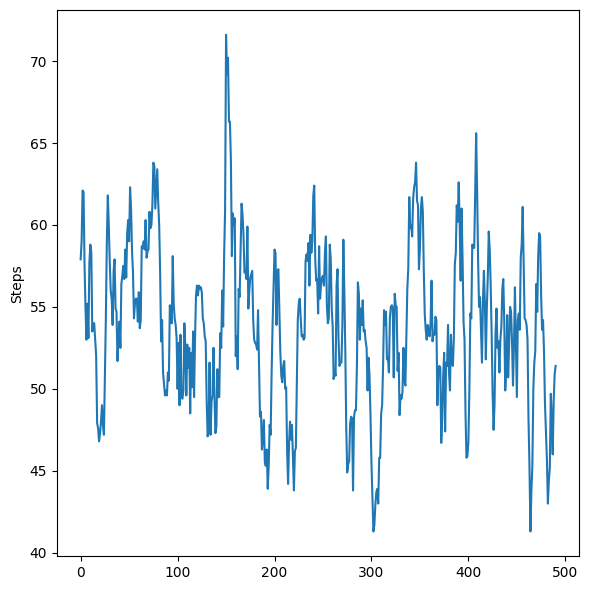

In [150]:

%matplotlib inline
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
window_size = 10

steps = np.convolve(train_hist["steps"],  np.ones(window_size)/window_size, mode='valid')

# Plot rewards
ax1.plot(steps)
ax1.set_ylabel('Steps')

plt.tight_layout()
plt.show()


[]

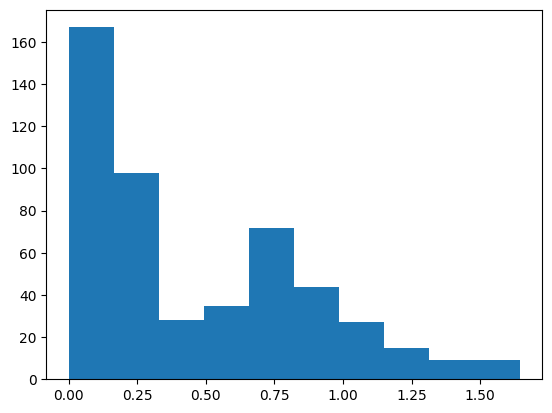

In [151]:
%matplotlib inline
polar_mat = sailor.polar

speeds = []
for key in polar_mat.keys():
    speeds.append(np.mean(polar_mat[key]))

fig, ax = plt.subplots()
ax.hist(speeds,bins=10)
plt.plot()
    

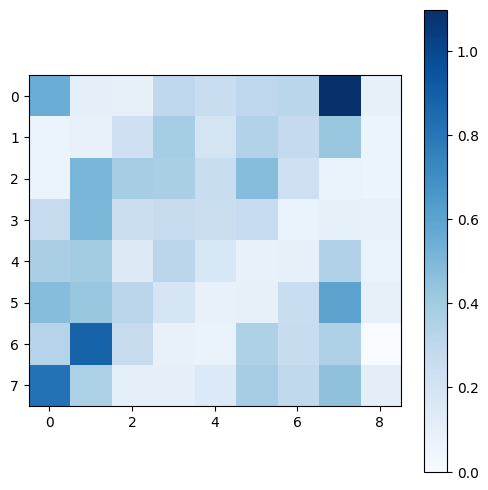

In [152]:
matrice = np.zeros((8,9))
count = np.ones((8,9))

for key in polar_mat.keys():
    wind_bin, wind_mag, action = key
    speed = np.mean(polar_mat[key])

    if wind_mag != 0:
        matrice[wind_bin][action] += speed / wind_mag
        count[wind_bin][action] += 1

for w in range(8):
    for a in range(9):
        matrice[wind_bin][action] /= count[wind_bin][action]

plt.figure(figsize=(6, 6))
plt.imshow(matrice, cmap='Blues')
plt.colorbar()
plt.show()

    

In [158]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML
%matplotlib notebook

n = np.random.randint(0, 100000)
results_steps, results_rew, results_avg_speed = test(sailor, num_test=1, max_steps=500, seed=[n])

coordinates = sailor.hist_pos
x_data = []
y_data = []

for x, y in coordinates:
    x_data.append(x)
    y_data.append(y)

# Initialisation de la figure et des axes
fig, ax = plt.subplots()
ax.set_xlim(0, 32)
ax.set_ylim(0, 32)
line, = ax.plot([], [], 'b-', lw=2)  # 'b-' signifie une ligne bleue
title = ax.set_title("Steps")


# Initialisation de la ligne
def init():
    line.set_data([], [])
    return line,

# Fonction d'animation
def animate(i):
    if i > 10:
        x = x_data[i-10:i]
        y = y_data[i-10:i]
    else:
        x = x_data[:i]
        y = y_data[:i]
    line.set_data(x, y)
    title.set_text(f"Steps - {i}")
    return line,

# Création de l'animation
ani = FuncAnimation(fig, animate, init_func=init, frames=len(coordinates), interval=50, blit=True)

# Affichage de l'animation dans un notebook Jupyter
HTML(ani.to_jshtml())

------ BEGINNING TEST -------------------------------                                
exploration rate set to : 0
Testing the trained agent on 1 new episodes...
exploration rate re-set to : 0.3
------ END OF TEST ----------------------------------                                


<IPython.core.display.Javascript object>

In [182]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

# Assurez-vous que le backend est configuré pour les animations interactives
%matplotlib notebook

# Supposons que sailor.q_table et les autres paramètres sont déjà définis
table = sailor.q_table
velocity_bins = sailor.velocity_bins
wind_bins = sailor.wind_bins

# Initialisation de la figure et des axes
fig, ax = plt.subplots()
cax = ax.matshow(np.zeros((32, 32)), vmin=0, vmax=9,cmap='tab10')  # Supposons que les valeurs vont de 0 à 8
plt.colorbar(cax)

ax.invert_yaxis()

def update(frame):
    v, w = frame
    matrice = np.zeros((32, 32))
    for key in table.keys():
        x, y, veloc, wind = key
        if veloc == v and wind == w:
            matrice[y][x] = np.argmax(table[key])

    cax.set_data(matrice)
    ax.set_title(f'Velocity Bin: {v}, Wind Bin: {w}')
    return [cax]

# Créer une liste de tous les cadres (frames) pour l'animation
frames = [(v, w) for v in range(velocity_bins) for w in range(wind_bins)]

# Créer l'animation
ani = FuncAnimation(fig, update, frames=frames, interval=500, blit=False)

# Afficher l'animation
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>

In [185]:
a = [0,1,1,1,0,-1,-1,-1]
b = [1,1,0,-1,-1,-1,0,1]

for ux, uy in zip(a, b):

    wind_direction = np.arctan2(uy, ux)
    wind_bin = int(((-wind_direction + 1/2*np.pi) / (2 * np.pi) * 8)) % 8
    print(wind_bin)

0
1
2
3
4
5
6
7
